# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [1]:
!pip install datasets torchmetrics

In [2]:
!pip install wandb

In [3]:
import wandb

# Initialize wandb
wandb.init(project='IMDB Sentiment Analysis')


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [5]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# Split the train set into train and validation in 80-20 split. 
train_data = imdb_dataset['train']
test_data = imdb_dataset['test']
# using labels ensure that the ratio of the samples from each class is maintained in the train and validation sets
train_data = train_data.train_test_split(test_size=0.2, seed=SEED)
val_data = train_data['test']
train_data = train_data['train']



In [9]:
def clean(text, tokenizer):
  # Perform text preprocessing:
  # You will experiment with stemming/lemmatization down the line
  # so you can skip that for now

  # substituting all the numbers with "num"
  text = re.sub(r'\d+', 'num', text)
  # removing all punctuations
  text = re.sub(r'[^\w\s]', '', text)
  # converting all the text to lowercase
  text = text.lower()
  # tokenizing the text using regexpTokenizer
  text = tokenizer.tokenize(text)

  return text

In [10]:
clean("This IS 1 example sentenc.", RegexpTokenizer(r'\w+'))

['this', 'is', 'num', 'example', 'sentenc']

In [11]:
from nltk.stem import SnowballStemmer

def cleanStemming(text, tokenizer):
    # Perform text preprocessing:
    # substituting all the numbers with "num"
    text = re.sub(r'\d+', 'num', text)
    # removing all punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # converting all the text to lowercase
    text = text.lower()
    # tokenizing the text using regexpTokenizer
    tokens = tokenizer.tokenize(text)
    # performing stemming
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens



In [12]:
cleanStemming("This is 1 example sentenc running.", RegexpTokenizer(r'\w+'))


['this', 'is', 'num', 'exampl', 'sentenc', 'run']

In [13]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

def get_word2idx(corpus, stemming = False):
  idx = 1
  word2idx = {}

  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
    # process sentence
    if stemming:
        sentence = cleanStemming(sentence, RegexpTokenizer(r'\w+'))
    else:
        sentence = clean(sentence, RegexpTokenizer(r'\w+'))
    # drop sentences greater than maxlen or less than minlen
    if len(sentence) > 500 or len(sentence) < 100:
      continue

    # for each word in sentence, check for entry in word2idx
    for word in sentence:
      if word not in word2idx:
        word2idx[word] = idx
        idx += 1

  return idx, word2idx

In [14]:
_, word2idx = get_word2idx(train_data['text'])


Creating word2idx: 100%|██████████| 20000/20000 [00:04<00:00, 4357.07it/s]


In [15]:
_, word2idx_stem = get_word2idx(train_data['text'], stemming=True)

Creating word2idx: 100%|██████████| 20000/20000 [01:20<00:00, 247.15it/s]


In [16]:
class IMDBDataset(Dataset):
    def __init__(self, dataset, split: str, minlen: int = 100, maxlen: int = 500, stemming: bool = False):
        self.count = 0  # total sentences you finally pick

        # count total number of lines
        total_lines = len(dataset)
        corpus = dataset["text"]

        input_data = []
        target_data = []

        for idx, sentence in tqdm(enumerate(corpus), total=total_lines, desc=f"Transforming input text [{split}]"):
            # process sentence
            if stemming:
                sentence = cleanStemming(sentence, RegexpTokenizer(r'\w+'))
            else:
                sentence = clean(sentence, RegexpTokenizer(r'\w+'))

            # drop sentences greater than maxlen or less than minlen
            if len(sentence) > maxlen or len(sentence) < minlen:
                continue
            
            # replace words with their index
            # if word not in word2idx then replace it with unknown token
            # since word indices start from 1 we replace them with 0
            sentenceInd = []
            for word in sentence:
                if(stemming):
                    if word in word2idx_stem:
                        sentenceInd.append(word2idx_stem[word])
                    else:
                        sentenceInd.append(word2idx_stem["unknown"])
                else:
                    if word in word2idx:
                        sentenceInd.append(word2idx[word])
                    else:
                        sentenceInd.append(word2idx["unknown"])
            # sentenceInd = [word2idx[word] for word in sentence]
            # appending tensor representation of indexed sentence to input_data
            input_data.append(torch.tensor(sentenceInd))
            # appending label to target_data
            target_data.append(dataset[idx]["label"])

            self.count += 1
            
        # pad the sentences up to maxlen
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]

In [17]:
# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(train_data, "train",minlen = 100, maxlen = 500)
# create the validation and test dataset using the word2idx dictionary built using the train set
valid_ds = IMDBDataset(val_data, "valid", minlen = 100, maxlen = 500)
test_ds = IMDBDataset(test_data, "test", minlen = 100, maxlen = 500)


Transforming input text [test]: 100%|██████████| 25000/25000 [00:10<00:00, 2415.00it/s]


In [18]:
len(train_ds), len(valid_ds), len(test_ds)

(16025, 4029, 20021)

In [19]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
valid_dataloader = DataLoader(valid_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [20]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        
        # Define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        # Embedding layer
        embedded = self.embedding(X)
        # RNN layer
        output, hidden = self.rnn(embedded)
        # Final output layer
        logits = self.fc(hidden.squeeze(0))
        
        return logits


In [21]:
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
vocab_size = len(word2idx) + 1
num_classes = 2

# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

print(model)

RNNModel(
  (embedding): Embedding(88859, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [22]:
def train_model(model, train_dataloader, valid_dataloader, epochs, lr=0.001):
    train_losses = []
    val_losses = []
    val_accuracy = []

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for input_batch, output_batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training"):
            # Zero the gradients
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_batch)
            
            # Compute the loss
            loss = criterion(outputs, output_batch)
            wandb.log({"Training Loss": loss.item()})
            
            # Backward pass
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Log metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += output_batch.size(0)
            correct_train += (predicted == output_batch).sum().item()

        # Calculate training loss and accuracy
        train_losses.append(train_loss / len(train_dataloader))
        train_accuracy = correct_train / total_train

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for input_batch, output_batch in tqdm(valid_dataloader, total=len(valid_dataloader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                # Forward pass
                
                outputs = model(input_batch)
                
                # Compute the loss
                loss = criterion(outputs, output_batch)
                wandb.log({"Validation Loss": loss.item()})
                
                # Log metrics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += output_batch.size(0)
                correct_val += (predicted == output_batch).sum().item()

        # Calculate validation loss and accuracy
        val_losses.append(val_loss / len(valid_dataloader))
        val_accuracy.append(correct_val / total_val)
        wandb.log({"Validation Accuracy": val_accuracy[-1]})

        # Save the best model
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model)

    return train_losses, val_losses, val_accuracy


In [23]:
# loop for testing the model
def testModel(model, test_dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_dataloader, total=len(test_dataloader), desc="Testing"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            # Forward pass
            outputs = model(input_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()
    return correct / total


In [24]:
# Create a model testing loop 
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, valid_dataloader, epochs, learning_rate)


Validation: 100%|██████████| 126/126 [00:00<00:00, 161.95it/s]


In [25]:
# testing the model
test_accuracy = testModel(model, test_dataloader)
print(f"Test accuracy: {test_accuracy}")


Testing: 100%|██████████| 626/626 [00:02<00:00, 231.21it/s]

Test accuracy: 0.5013735577643474


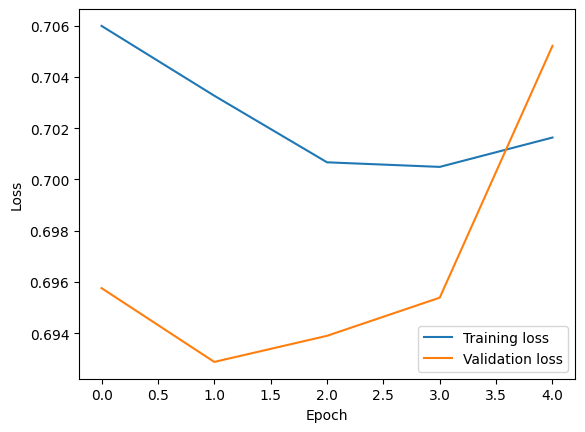

In [26]:
# plot training and validation losses
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


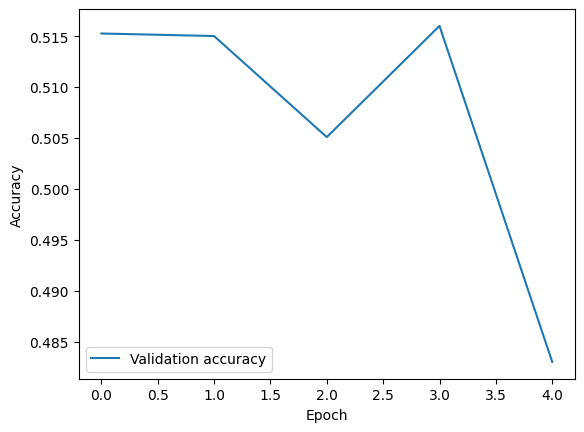

In [27]:
# plot validation accuracy
plt.plot(val_accuracy, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [28]:
# create the train dataset using the word2idx dictionary built using the train set
train_ds_stem = IMDBDataset(train_data, "train",minlen = 100, maxlen = 500, stemming = True)
# create the validation and test dataset using the word2idx dictionary built using the train set
valid_ds_stem = IMDBDataset(val_data, "valid", minlen = 100, maxlen = 500, stemming=True)
test_ds_stem = IMDBDataset(test_data, "test", minlen = 100, maxlen = 500, stemming=True)


Transforming input text [test]: 100%|██████████| 25000/25000 [01:43<00:00, 242.49it/s]


In [29]:
len(train_ds_stem), len(valid_ds_stem), len(test_ds_stem)

(16025, 4029, 20021)

In [30]:
train_dataloader_stem = DataLoader(train_ds_stem, **params)
valid_dataloader_stem = DataLoader(valid_ds_stem, **params)
test_dataloader_stem = DataLoader(test_ds_stem, **params)

In [31]:
model_stem = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)
print(model_stem)

RNNModel(
  (embedding): Embedding(88859, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [32]:
# Create a model testing loop 
train_losses_stem, val_losses_stem, val_accuracy_stem = train_model(model_stem, train_dataloader_stem, valid_dataloader_stem, epochs, learning_rate)


Validation: 100%|██████████| 126/126 [00:00<00:00, 177.50it/s]


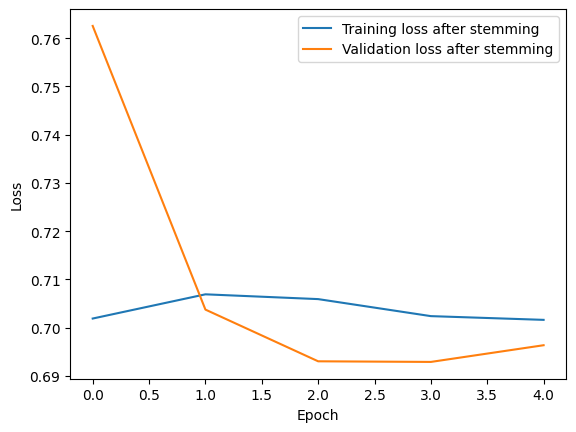

In [33]:
# plot training and validation losses
plt.plot(train_losses_stem, label="Training loss after stemming")
plt.plot(val_losses_stem, label="Validation loss after stemming")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


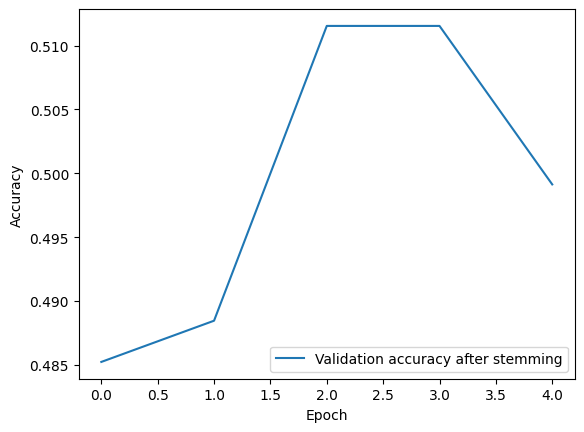

In [34]:
# plot validation accuracy
plt.plot(val_accuracy_stem, label="Validation accuracy after stemming")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [35]:
# testing the model
test_accuracy_stem = testModel(model_stem, test_dataloader_stem)
print(f"Test accuracy for stemming: {test_accuracy_stem}")


Testing: 100%|██████████| 626/626 [00:02<00:00, 227.73it/s]

Test accuracy for stemming: 0.5092153239098947


#### Report

Stemming simplifies words by reducing them to their root form. This consolidation helps the model focus better on core meanings, improving generalization and learning from the data, resulting in a slight accuracy boost.

#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [36]:
class RNNModel2(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, rnn_type):
        super(RNNModel2, self).__init__()
        # Define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.rnn_type = rnn_type  

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        if self.rnn_type == 'last_output':
            output = output[:, -1, :]  
        elif self.rnn_type == 'mean_output':
            output = torch.mean(output, dim=1) 
        output = self.fc(output)
        return output


In [37]:
model_last = RNNModel2(vocab_size, hidden_size, embedding_dim, num_classes, rnn_type = "last_output").to(device)
print(model_last)

RNNModel2(
  (embedding): Embedding(88859, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [38]:
# Create a model testing loop 
train_losses, val_losses, val_accuracy = train_model(model_last, train_dataloader, valid_dataloader, epochs, learning_rate)

Validation: 100%|██████████| 126/126 [00:00<00:00, 178.07it/s]


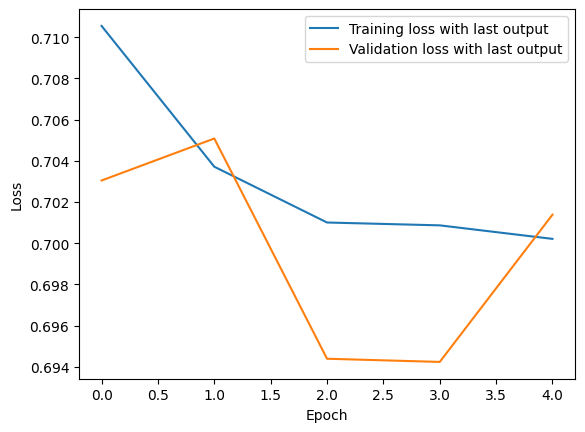

In [39]:
# plot training and validation losses
plt.plot(train_losses, label="Training loss with last output")
plt.plot(val_losses, label="Validation loss with last output")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


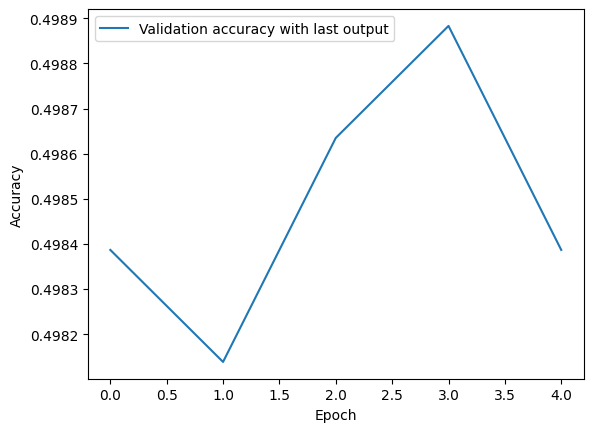

In [40]:
# plot validation accuracy
plt.plot(val_accuracy, label="Validation accuracy with last output")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [41]:
# testing the model
test_accuracy = testModel(model_last, test_dataloader)
print(f"Test accuracy RNN with last output: {test_accuracy}%")


Testing: 100%|██████████| 626/626 [00:02<00:00, 228.31it/s]

Test accuracy RNN with last output: 0.5090155336896259%


In [42]:
model_mean = RNNModel2(vocab_size, hidden_size, embedding_dim, num_classes, rnn_type = "mean_output").to(device)
print(model_mean)

RNNModel2(
  (embedding): Embedding(88859, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [43]:
# Create a model testing loop 
train_losses, val_losses, val_accuracy = train_model(model_mean, train_dataloader, valid_dataloader, epochs, learning_rate)

Validation: 100%|██████████| 126/126 [00:00<00:00, 175.97it/s]


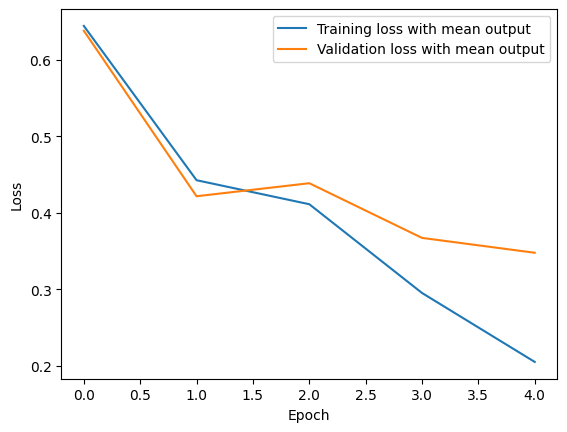

In [44]:
# plot training and validation losses
plt.plot(train_losses, label="Training loss with mean output")
plt.plot(val_losses, label="Validation loss with mean output")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


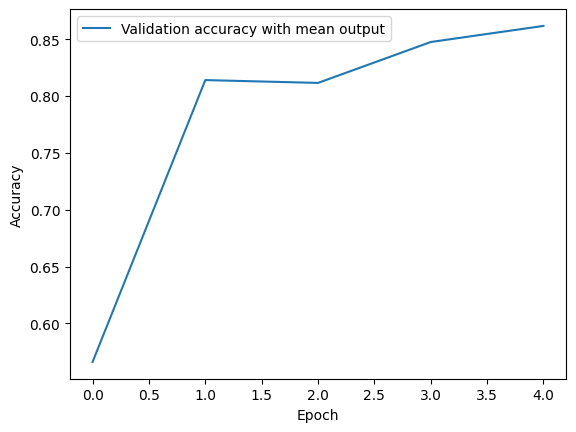

In [45]:
# plot validation accuracy
plt.plot(val_accuracy, label="Validation accuracy with mean output")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [46]:
# testing the model
test_accuracy = testModel(model_mean, test_dataloader)
print(f"Test accuracy RNN with mean output: {test_accuracy}%")


Testing: 100%|██████████| 626/626 [00:02<00:00, 226.09it/s]

Test accuracy RNN with mean output: 0.8397182957894211%


#### Report

- RNN with only the final output disregards information from previous time steps, hindering its ability to capture the full context of longer sequences. This limitation results in lower accuracy compared to models leveraging information from all time steps.
- The model with mean output aggregates information from every time step, capturing the full context and dependencies within the input. This perspective enables more informed predictions, leading to higher accuracy.

### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [47]:
configurations = [
    {'embedding_dim': 100, 'hidden_size': 128, 'batch_size': 64},
    {'embedding_dim': 100, 'hidden_size': 128, 'batch_size': 64},
    {'embedding_dim': 200, 'hidden_size': 256, 'batch_size': 128},
    {'embedding_dim': 50, 'hidden_size': 64, 'batch_size': 32},
    {'embedding_dim': 150, 'hidden_size': 192, 'batch_size': 96},
    {'embedding_dim': 75, 'hidden_size': 96, 'batch_size': 48}
]


In [48]:
# using model with mean of output layer as that gave the best result previously
for i, config in enumerate(configurations):

    print(f'Experiment {i+1} with Configuration: {config}')
    
    # Update hyperparameters
    embedding_dim = config['embedding_dim']
    hidden_size = config['hidden_size']
    batch_size = config['batch_size']
    train_dataloader = DataLoader(train_ds, batch_size)
    valid_dataloader = DataLoader(valid_ds, batch_size)
    test_dataloader = DataLoader(test_ds, batch_size)

    # Initialize the LSTM model
    model_mean = RNNModel2(vocab_size, embedding_dim, hidden_size, num_classes, rnn_type = "mean_output").to(device)

    # Train the LSTM model
    train_losses, val_losses, val_accuracy = train_model(model_mean, train_dataloader, valid_dataloader, 5, learning_rate)

    test_accuracy = testModel(model_mean, test_dataloader)
    print(f"Test accuracy of RNN: {test_accuracy}%")


Experiment 1 with Configuration: {'embedding_dim': 100, 'hidden_size': 128, 'batch_size': 64}


Testing: 100%|██████████| 313/313 [00:00<00:00, 458.61it/s]


Test accuracy of RNN: 0.8099995005244494%
Experiment 2 with Configuration: {'embedding_dim': 100, 'hidden_size': 128, 'batch_size': 64}


Testing: 100%|██████████| 313/313 [00:00<00:00, 458.42it/s]


Test accuracy of RNN: 0.8140952000399581%
Experiment 3 with Configuration: {'embedding_dim': 200, 'hidden_size': 256, 'batch_size': 128}


Testing: 100%|██████████| 157/157 [00:01<00:00, 137.24it/s]


Test accuracy of RNN: 0.8275810399080965%
Experiment 4 with Configuration: {'embedding_dim': 50, 'hidden_size': 64, 'batch_size': 32}


Testing: 100%|██████████| 626/626 [00:00<00:00, 639.02it/s]


Test accuracy of RNN: 0.8145447280355627%
Experiment 5 with Configuration: {'embedding_dim': 150, 'hidden_size': 192, 'batch_size': 96}


Testing: 100%|██████████| 209/209 [00:00<00:00, 241.07it/s]


Test accuracy of RNN: 0.8237850257229908%
Experiment 6 with Configuration: {'embedding_dim': 75, 'hidden_size': 96, 'batch_size': 48}


Testing: 100%|██████████| 418/418 [00:00<00:00, 536.87it/s]

Test accuracy of RNN: 0.829129414115179%


#### Report

- Embedding Dimension increase improves accuracy by capturing richer word relationships. Its reduce reduces accuracy due to limited representation capacity.
- Hidden Size increase enhances accuracy by enabling the model to learn more complex patterns.
- Batch Size increase helps improve accuracy by speeding up convergence. its decrease can reduce accuracy due to increased variance in gradient updates, slowing convergence.

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [49]:
import torch.nn as nn

class RNNModelLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModelLSTM, self).__init__()
        
        # Define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        # Embedding layer
        embedded = self.embedding(X)
        # lstm layer
        output, (hidden, cn) = self.lstm(embedded)
        output = torch.mean(output, dim=1) 
        # Final output layer
        output = self.fc(output)        
        return output


In [50]:
model_lstm = RNNModelLSTM(vocab_size, hidden_size, embedding_dim, num_classes).to(device)
print(model_lstm)

RNNModelLSTM(
  (embedding): Embedding(88859, 75)
  (lstm): LSTM(75, 96, batch_first=True)
  (fc): Linear(in_features=96, out_features=2, bias=True)
)


In [51]:
# Create a model testing loop 
train_losses, val_losses, val_accuracy = train_model(model_lstm, train_dataloader, valid_dataloader, epochs, learning_rate)

Validation: 100%|██████████| 84/84 [00:00<00:00, 273.58it/s]


In [52]:
# testing the model
test_accuracy = testModel(model_lstm, test_dataloader)
print(f"Test accuracy RNN with lstm output: {test_accuracy}")


Testing: 100%|██████████| 418/418 [00:01<00:00, 329.57it/s]

Test accuracy RNN with lstm output: 0.8222366515159083


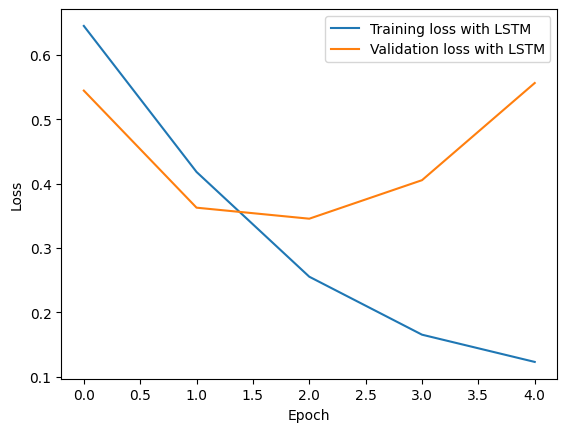

In [53]:
# plot training and validation losses
plt.plot(train_losses, label="Training loss with LSTM")
plt.plot(val_losses, label="Validation loss with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


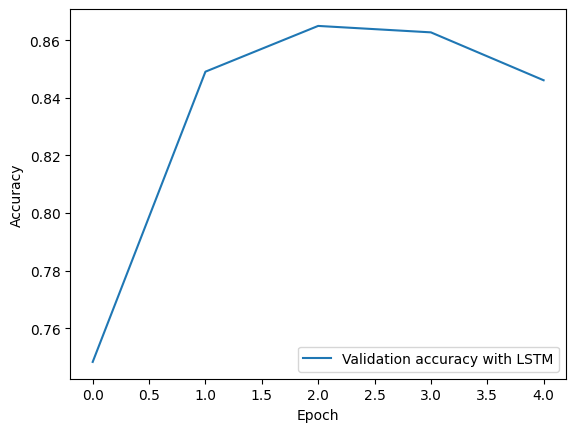

In [54]:
# plot validation accuracy
plt.plot(val_accuracy, label="Validation accuracy with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#### Report


LSTM models showed slightly better accuracy than RNN models. LSTMs are adept at capturing long-range dependencies in sequential data, leading to improved information preservation and utilization over longer sequences, hence the slight performance boost.